# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
# Загрузим необходимые библиотеки для проекта
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import *
from sklearn.utils import shuffle
from scipy import stats as st
from numpy.random import RandomState
import warnings
random_state = np.random.RandomState(12345)

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты  и настройки на месте
</div>

In [107]:
# функция определения выбросов по правилу 3 сигм
def outlier(data):
    data_mean, data_std = np.mean(data), np.std(data)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in data if x < lower or x > upper]
    outliers_removed = [x for x in data if x >= lower and x <= upper]
    return len(outliers)

#  функция для описания статистик: 
def describe_full_stat(df, target_name=""):
    data_describe = df.describe().T
    df_numeric = df._get_numeric_data()
    if target_name in df.columns:
        corr_with_target=df_numeric.drop(target_name, axis=1).apply(lambda x: x.corr(df_numeric[target_name]))
        data_describe['corr_with_target']=corr_with_target
    dtype_df = df_numeric.dtypes
    data_describe['dtypes'] = dtype_df
    data_null = df_numeric.isnull().sum()/len(df) * 100
    data_describe['Missing %'] = data_null
    Cardinality = df_numeric.apply(pd.Series.nunique)
    data_describe['Cardinality'] = Cardinality
    df_skew = df_numeric.skew(axis=0, skipna=True)
    data_describe['Skew'] = df_skew
    data_describe['outliers']=[outlier(df_numeric[col]) for col in df_numeric.columns]
    data_describe['kurtosis']=df_numeric.kurtosis()
    return data_describe


#  функция для отображения графика плотностей в датафрейме по группам: 
def dspl_group_density_plt(df, groupby, on, palette, figsize):
    """
Отображает график плотности по группам, учитывая непрерывную переменную, и группу для разделения данных.
     :param df: DataFrame для отображения данных
     :param groupby: Имя столбца, по которому будут сгруппированы графики (категориальный, максимум 10 категорий)
     :param on: Имя столбца для различных графиков плотности
     :param палитра: Цветовая палитра для рисования.
     :param figsize: Размер фигуры
     : return: объект matplotlib.axes._subplots.AxesSubplot
    """

    if not isinstance(df, pd.core.frame.DataFrame):
        raise ValueError('df must be a pandas DataFrame')

    if not groupby:
        raise ValueError('groupby parameter must be provided')

    elif not groupby in df.keys():
        raise ValueError(groupby + ' column does not exist in the given DataFrame')

    if not on:
        raise ValueError('on parameter must be provided')

    elif not on in df.keys():
        raise ValueError(on + ' column does not exist in the given DataFrame')

    if len(set(df[groupby])) > 10:
        groups = df[groupby].value_counts().index[:10]

    else:
        groups = set(df[groupby])

    # Get relevant palette
    if palette:
        palette = palette[:len(groups)]
    else:
        palette = sns.color_palette()[:len(groups)]

    # Plot
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    for value, color in zip(groups, palette):
        sns.kdeplot(df.loc[df[groupby] == value][on], \
                    shade=True, color=color, label=value)

    ax.set_title(str("Плотность значений Product по регионам"),\
                 fontsize=30)
    ax.legend(bbox_to_anchor=(1.04, 1), loc='best')


    ax.set_xlabel(on, fontsize=20)
    return ax

<div class="alert alert-block alert-success">
<b>Успех:</b> Хороший помощник
</div>


<div class="alert alert-block alert-info">
<b>Совет:</b>  Советую обратить внимание на библиотеки sweetviz и pandas_profiling помогут в проведении более тщательного EDA анализа. Исследовательский анализ можно делать и с помощью ручного вызова функций дефолтных библиотек. Данные библиотеки хороши для максимизации комфорта презентации результатов анализа бизнес-пользователям.  

Очень просты в использоовании, на вход кладется датафрейм: pandas_profiling.ProfileReport(df) 
</div>


In [3]:
df_0 = pd.read_csv("/datasets/geo_data_0.csv")
df_1 = pd.read_csv("/datasets/geo_data_1.csv")
df_2 = pd.read_csv("/datasets/geo_data_2.csv")


In [4]:
df_0.head()


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
df_1.head()


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
df_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [7]:
df_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [8]:
df_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [9]:
df_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [10]:
describe_full_stat(df_0, target_name='product')

,count,mean,std,min,25%,50%,75%,max,corr_with_target,dtypes,Missing %,Cardinality,Skew,outliers,kurtosis
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331,0.143536,float64,0.0,100000,-0.000337,0,-0.868909
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769,-0.192356,float64,0.0,100000,0.000717,0,-1.186068
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790,0.483663,float64,0.0,100000,-0.002996,178,-0.111284
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347,NaN,float64,0.0,100000,0.004816,0,-0.951506


In [11]:
describe_full_stat(df_1, target_name='product')

,count,mean,std,min,25%,50%,75%,max,corr_with_target,dtypes,Missing %,Cardinality,Skew,outliers,kurtosis
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755,-0.030491,float64,0.0,100000,0.001992,7,-0.947124
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063,-0.010155,float64,0.0,100000,0.016597,262,-0.023065
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721,0.999397,float64,0.0,100000,0.006666,0,-1.261794
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408,NaN,float64,0.0,12,0.006685,0,-1.259374


In [12]:
describe_full_stat(df_2, target_name='product')

,count,mean,std,min,25%,50%,75%,max,corr_with_target,dtypes,Missing %,Cardinality,Skew,outliers,kurtosis
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262,-0.001987,float64,0.0,100000,0.003941,266,0.015364
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801,-0.001012,float64,0.0,100000,0.014802,281,-0.012328
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402,0.445871,float64,0.0,100000,0.004057,201,-0.068082
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838,NaN,float64,0.0,100000,0.004655,0,-0.878423


In [13]:
target = "product"
features = ['f0', 'f1', 'f2']

df0 = df_0.copy()
df0["file"] = "region_df_0"
df1 = df_1.copy()
df1["file"] = "region_df_1"
df2 = df_2.copy()
df2["file"] = "region_df_2"
df = pd.concat([df0, df1, df2])
del df0,df1,df2

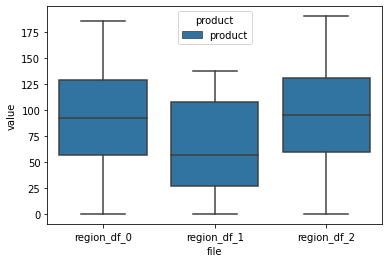

<Figure size 432x288 with 0 Axes>

In [14]:
melted_df = pd.melt(df[[target, 'file']], id_vars=['file'], var_name=[target])
ax = sns.boxplot(x="file", y="value", hue=target, data=melted_df)    
plt.show()
plt.clf()

In [15]:
melted_df

,file,product,value
0,region_df_0,product,105.280062
1,region_df_0,product,73.037750
2,region_df_0,product,85.265647
3,region_df_0,product,168.620776
4,region_df_0,product,154.036647
...,...,...,...
299995,region_df_2,product,172.327046
299996,region_df_2,product,138.748846
299997,region_df_2,product,157.080080
299998,region_df_2,product,51.795253


<AxesSubplot:title={'center':'Плотность значений Product по регионам'}, xlabel='value', ylabel='Density'>

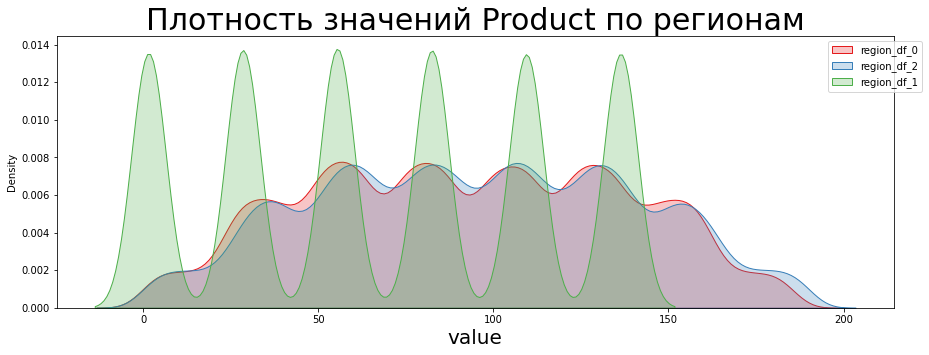

In [108]:
dspl_group_density_plt(melted_df, groupby = "file", on = 'value', palette = sns.color_palette('Set1'),\
                       figsize = (15, 5))

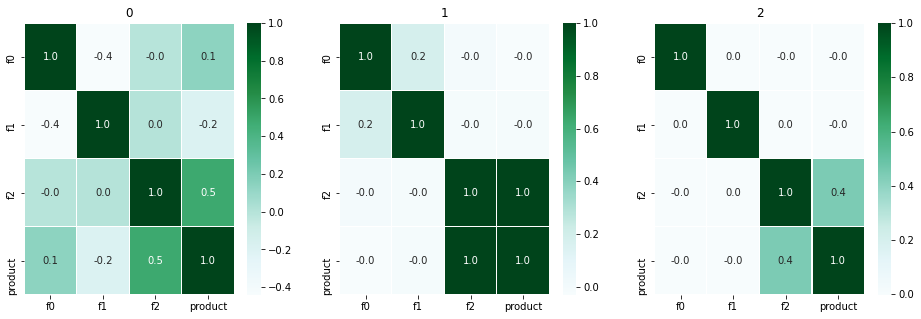

In [17]:
fig, ax = plt.subplots(1,3,figsize=(16,5))
for i,j in zip([df_0,df_1,df_2],range(3)):    
    sns.heatmap(i.corr(),annot=True, linewidths=.1, fmt= '.1f', ax=ax[j], cmap="BuGn")
    ax[j].set_title(str(j))

#### Выводы
* В каждом df по 100 тыс. наблюдений.
* У df нет пропущенных значений и адекватные типы данных.
* Признак f2 коррелирует с product, особенно в df_1
* У df_1 уникальных значений в product 12.
* Распределения значений целевого признака Product в df_0 и df_2 очень похожи, в df_1, напротив, распределение очень отличается



<div class="alert alert-block alert-success">
<b>Успех:</b> Данные осмотрены хорошо, особенно радует, что изучены корреляции, так как мы планируем использовать линейные модели, а для них это важно. 
</div>

<div class="alert alert-block alert-info">
<b>Совет:</b> Можно было бы еще выдвинуть предположение, откуда такая высокая корреляция во 2 регионе с целевым признаком могла возникнуть
</div>



## Обучение и проверка модели

<font color = 'green'> 
1. RMSE (Root Mean Squared Error) - корень из среднеквадратичной ошибки. RMSE является мерой разности между значениями, предсказанными моделью, и фактическими значениями. RMSE вычисляется как квадратный корень из среднего значения квадратов ошибок (разности между фактическими и предсказанными значениями). Чем меньше RMSE, тем лучше качество модели, поскольку ошибки предсказаний меньше. Однако следует сравнивать RMSE только между моделями с похожими единицами измерения.

2. R^2 (коэффициент детерминации) - статистическая мера, показывающая долю дисперсии зависимой переменной, объясняемой моделью регрессии. R^2 принимает значения от 0 до 1, где 1 означает, что модель объясняет 100% дисперсии зависимой переменной. Чем выше R^2, тем лучше модель объясняет изменчивость данных. Однако стоит быть осторожным, поскольку R^2 может быть завышенным в случае сложных моделей или наличия многочисленных незначимых переменных.

3. Score - в контексте линейной регрессии обычно означает коэффициент детерминации R^2, хотя в зависимости от используемой библиотеки и контекста, score может относиться к другим метрикам. В случае линейной регрессии, используя функцию score() из библиотеки scikit-learn, вы получите значение R^2.

В целом, при оценке модели линейной регрессии обычно анализируются RMSE и R^2. Низкое значение RMSE и высокое значение R^2 свидетельствуют о хорошем качестве модели. Однако важно помнить, что метрики следует рассматривать в комплексе и учитывать особенности задачи и данных. <font>

In [18]:
def test_LinearRegression_model(X_train, X_valid, y_train, y_valid):
    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_valid)  
    return mean_squared_error(y_valid, y_pred,squared=False), model.score(X_valid, y_valid), y_pred

In [19]:
target = "product"
features = ['f0', 'f1', 'f2']

In [20]:
X_train0,X_valid0,y_train0,y_valid0 = train_test_split(df_0[features].values,df_0[target].values,test_size=0.25, random_state=random_state)
rmse, score, y_pred0 = test_LinearRegression_model(X_train0,X_valid0,y_train0,y_valid0)
print(f"RMSE: {rmse}")
print(f"R^2: {score}")
print(f"y_pred_mean: {y_pred0.mean()}")

RMSE: 37.5794217150813
R^2: 0.27994321524487786
y_pred_mean: 92.59256778438028


In [22]:
X_train0,X_valid0,y_train0,y_valid0 = train_test_split(df_0[features].values,df_0[target].values,test_size=0.25, random_state=random_state)
                                    
rmse, score, y_pred0 = test_LinearRegression_model(X_train0,X_valid0,y_train0,y_valid0)
print(f"RMSE: {rmse}")
print(f"R^2: {score}")
print(f"y_pred_mean: {y_pred0.mean()}")

RMSE: 37.91718878682678
R^2: 0.2627416782534465
y_pred_mean: 92.40129321593419


In [25]:
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(df_1[features].values,df_1[target]\
                                                          .values, test_size=0.25, random_state=random_state)
rmse, score, y_pred1 = test_LinearRegression_model(X_train1, X_valid1, y_train1, y_valid1)
print(f"RMSE: {rmse}")
print(f"R^2: {score}")
print(f"y_pred_mean: {y_pred1.mean()}")

RMSE: 0.8936594805070874
R^2: 0.9996231409804716
y_pred_mean: 69.24215404831628


In [26]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(df_2[features].values,df_2[target]\
                                                          .values, test_size=0.25, random_state=random_state)
rmse, score, y_pred2 = test_LinearRegression_model(X_train2, X_valid2, y_train2, y_valid2)
print(f"RMSE: {rmse}")
print(f"R^2: {score}")
print(f"y_pred_mean: {y_pred2.mean()}")

RMSE: 40.206897848340155
R^2: 0.19259794621965654
y_pred_mean: 94.79275536960408


In [27]:
def cross_valid_model(df):
    """
    cross-validation checker of linear regression model 
    (also we could use LinearRegressionCV)
    """
    shuffle(df)
    X, y = df[features].values, df[target].values
    result = dict(rmse=[], score=[])
    for train_index, valid_index in KFold(n_splits=5).split(X):
        scaler = StandardScaler()
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)
        rmse, score, _ = test_LinearRegression_model(X_train, X_valid, y_train, y_valid)
        result["rmse"].append(rmse)
        result["score"].append(score)
    return pd.DataFrame(result)

In [28]:
cross_valid_model(df_0).describe().T['mean']

rmse     37.694273
score     0.275491
Name: mean, dtype: float64

In [29]:
cross_valid_model(df_1).describe().T['mean']

rmse     0.890408
score    0.999624
Name: mean, dtype: float64

In [30]:
cross_valid_model(df_2).describe().T['mean']

rmse     40.056880
score     0.198716
Name: mean, dtype: float64

Получили следующие значения моделей Линейной регрессии:

df_0: RMSE: 37.76;  𝑅2 : 0.27; y_pred_mean: 92.40;

df_1: RMSE: 0.89;  𝑅2 : 0.99; y_pred_mean: 68.71;

df_2: RMSE: 40.15;  𝑅2 : 0.19; y_pred_mean: 94.77;

Кросс-валидация модели:

df_0: RMSE: 37.69;  𝑅2 : 0.27; 

df_1: RMSE: 0.89;  𝑅2 : 0.99; 

df_2: RMSE: 0.40;  𝑅2 : 0.19; 


#### Выводы
* Модель на df_0 и df_2 данных показывает высокое среднее прогнозируемое значение, 92 и 94
* Модель на df_1 показала высокие результаты - низкий RMSE и высокий коэфф. детерминации R^2, так как в целевой метрике всего 12 уникальных значений. При этом низкое среднее прогнозируемое значение - 68. 


<div class="alert alert-block alert-success">
<b>Успех:</b> Шаг проделан лаконично, все метрики посчитаны корректно
</div> 



## Подготовка к расчёту прибыли

In [31]:
#По условия задачи дано:

budget = 10000000000   # Бюджет на разработку скважин в регионе — 10 млрд рублей.
total_points = 500 # При разведке исследуют 500 точек
profit_points = 200  # Из которых с помощью машинного обучения выбирают 200 лучших точек для разработки
profit_per_barrel = 450   # Доход с одного барреля 450 руб.
profit_per_product = 450000   # Доход с каждой единицы продукта 450 тыс. руб.


<div class="alert alert-block alert-info">
    
<b>Совет:</b> Константы принято записывать в ВЕРХНЕМ РЕГИСТРЕ =) Читем здесь https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html#section-29
    
А большие значение можно записывать так: `10_000_000_000`.
</div> 


In [32]:
min_product_volume = budget/profit_points/profit_per_product

print(f"Мин. объем запасов на скважину, чтобы добыча из нее была рентабельна = {min_product_volume:.2f}")

Мин. объем запасов на скважину, чтобы добыча из нее была рентабельна = 111.11


<div class="alert alert-block alert-success">
<b>Успех:</b> Значение для безубыточной разработки посчитано верно
</div>

In [96]:
#Напишем функцию для расчета прибыли по скважинам и предсказаниям модели. 

def revenue(target, predicted, count):
    indexes = predicted.sort_values(ascending=False).index #сортируем значения и объявляем индексы отсортированых значений предсказаний
    return target[indexes][:count].sum() * profit_per_product - budget # берем целевые значения по индексам и до count, далее суммируем и умножаем на доход с продукта и вычитаем бюджет


<div class="alert alert-block alert-success">
<b>Успех:</b> Ф-ция для подсчета прибыли определена верно
</div>

In [97]:
# Целевые и предсказанные значения по регионам. target - цель, predictions - предсказание
target_ser_0 = pd.Series(y_valid0) 
predictions_ser_0 = pd.Series(y_pred0)

target_ser_1 = pd.Series(y_valid1) 
predictions_ser_1 = pd.Series(y_pred1)

target_ser_2 = pd.Series(y_valid2) 
predictions_ser_2 = pd.Series(y_pred2)

In [98]:
# Применяем функцию и переведем в формат миллиардов
print('Прибыль региона 0: {:.2f} млрд рублей'.format(revenue(target_ser_0, predictions_ser_0, 200)/10**9))
print('Прибыль региона 1: {:.2f} млрд рублей'.format(revenue(target_ser_1, predictions_ser_1, 200)/10**9))
print('Прибыль региона 2: {:.2f} млрд рублей'.format(revenue(target_ser_2, predictions_ser_2, 200)/10**9))


Прибыль региона 0: 3.27 млрд рублей
Прибыль региона 1: 2.42 млрд рублей
Прибыль региона 2: 2.33 млрд рублей


* Чтобы экономика сходилась, нужно выбирать скважины как минимум с 111.11 тыс баррелей сырья.
* Среднее предсказанное значение продукции: регион_0 = 92 тыс. бареллей, регион_1 = 68 тыс. бареллей, регион_2 = 94 тыс. бареллей

<div class="alert alert-block alert-success">
<b>Успех:</b> с выводом согласен  
</div>

## Расчёт прибыли и рисков 

In [61]:
# функция - генерирует 1000 выборок, n_sample = 500
def bootstrap_revenue(target, predicted):
    target = pd.Series(target)
    predicted = pd.Series(predicted)
    values = []
    for i in range(1000):
        target_sample = target.sample(n = 500, replace = True, random_state = random_state)
        values.append(revenue(target_sample, predicted[target_sample.index], 200))
    return pd.Series(values)


<div class="alert alert-block alert-success">
<b>Успех:</b> С бутстрапом тоже все в порядке
</div>

In [62]:
revenue_0 = bootstrap_revenue(target_ser_0, predictions_ser_0)
revenue_1 = bootstrap_revenue(target_ser_1, predictions_ser_1)
revenue_2 = bootstrap_revenue(target_ser_2, predictions_ser_2)

In [63]:
format(len(revenue_0[revenue_0 < 0])/len(revenue_0), '.3f')


'0.091'

In [64]:
format(len(revenue_1[revenue_1 < 0])/len(revenue_1), '.3f')


'0.003'

In [65]:
format(len(revenue_2[revenue_2 < 0])/len(revenue_2), '.3f')


'0.093'

В целом скважины в регионах прибыльные, но есть и убыточные случаи

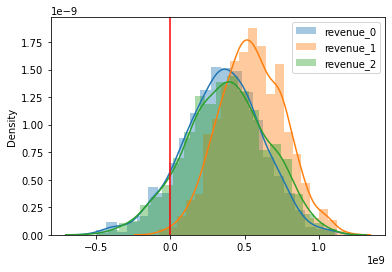

In [66]:
sns.distplot(revenue_0, label='revenue_0')
sns.distplot(revenue_1, label='revenue_1')
sns.distplot(revenue_2, label='revenue_2')
plt.axvline(0, c="r", label="")
plt.legend()
plt.show()

<font color = 'green'> 
Функция st.t.interval() является функцией из библиотеки SciPy (модуль stats) в языке программирования Python и используется для вычисления доверительного интервала t-распределения Стьюдента. Доверительный интервал используется для оценки диапазона, в котором с заданной вероятностью (уровень доверия) лежит истинное значение параметра (например, среднее арифметическое генеральной совокупности).

Аргументы функции st.t.interval() следующие:

1. alpha (float): Уровень доверия, который обычно задается в диапазоне от 0 до 1. Например, для 95% доверительного интервала установите alpha = 0.95.

2. df (int или float): Количество степеней свободы (degrees of freedom). Это значение зависит от количества наблюдений или размера выборки. Обычно количество степеней свободы равно n - 1, где n - количество наблюдений.

3. loc (float, по умолчанию 0): Ожидаемое среднее значение распределения. В контексте доверительных интервалов это будет выборочное среднее.

4. scale (float, по умолчанию 1): Масштабное значение (стандартная ошибка среднего), которое является оценкой стандартного отклонения генеральной совокупности, деленной на квадратный корень из размера выборки.

Функция возвращает кортеж из двух чисел, представляющих нижнюю и верхнюю границы доверительного интервала.
</font> 



<div class="alert alert-block alert-info">
<b>Совет: </b>
   
Вызывая **`st.t.interval(...)`**, ты находишь 95%-доверительный интервал для значения **`средней прибыли`**, то есть промежуток, в котором с большой вероятностью при проведении аналогичных экспериментов окажется **`средняя прибыль`**. По заданию требовалось оценить 95%-доверительный интервал для значения **`прибыли`**, то есть найти такой промежуток, в котором с большой вероятностью окажется **`прибыль`**, случайно выбранного месторождения данного региона. Нижняя граница этого интервала – это 2.5%-квантиль полученных значений прибыли, верхняя граница – 97.5%-квантиль.
</div>


In [43]:
conf_interval_0 = st.t.interval(alpha=0.95, df = len(revenue_0)-1, loc = revenue_0.mean(), scale = revenue_0.sem())
loss_risk_0 = len(revenue_0[revenue_0 < 0]) / len(revenue_0)
print(f""" Средняя прибыль с "региона_0" {revenue_0.mean():.2f}, 95% доверительный интервал ({conf_interval_0[0]:.2f}, {conf_interval_0[1]:.2f}) \
и риск потерь {loss_risk_0:.2%}""")

 Средняя прибыль с "региона_0" 351662243.05, 95% доверительный интервал (334760215.06, 368564271.03) и риск потерь 10.20%


In [91]:
conf_interval_1 = st.t.interval(alpha=0.95, df = len(revenue_1)-1, loc = revenue_1.mean(), scale = revenue_1.sem())
loss_risk_1 = len(revenue_1[revenue_1 < 1]) / len(revenue_1)
print(f""" Средняя прибыль с "региона_1" {revenue_1.mean():.2f}, 95% доверительный интервал ({conf_interval_1[0]:.2f}, {conf_interval_1[1]:.2f}) \
и риск потерь {loss_risk_1:.2%}""")

 Средняя прибыль с "региона_1" 550726935.80, 95% доверительный интервал (537306755.35, 564147116.26) и риск потерь 0.30%


In [92]:
conf_interval_2 = st.t.interval(alpha=0.95, df = len(revenue_2)-1, loc = revenue_2.mean(), scale = revenue_2.sem())
loss_risk_2 = len(revenue_2[revenue_2 < 1]) / len(revenue_2)
print(f""" Средняя прибыль с "региона_2" {revenue_2.mean():.2f}, 95% доверительный интервал ({conf_interval_2[0]:.2f}, {conf_interval_2[1]:.2f}) \
и риск потерь {loss_risk_2:.2%}""")

 Средняя прибыль с "региона_2" 380008194.63, 95% доверительный интервал (362638123.69, 397378265.56) и риск потерь 9.30%


#### Выводы
* В каждом df по 100 тыс. наблюдений.
* У df нет пропущенных значений и адекватные типы данных.
* Признак f2 коррелирует с product, особенно в df_1
* У df_1 уникальных значений в product 12.
* Распределения значений целевого признака Product в df_0 и df_2 очень похожи, в df_1, напротив, распределение очень отличается

Получили следующие значения моделей Линейной регрессии:

df_0: RMSE: 37.76;  𝑅2 : 0.27; y_pred_mean: 92.40;

df_1: RMSE: 0.89;  𝑅2 : 0.99; y_pred_mean: 68.71;

df_2: RMSE: 40.15;  𝑅2 : 0.19; y_pred_mean: 94.77;

Кросс-валидация модели:

df_0: RMSE: 37.69;  𝑅2 : 0.27; 

df_1: RMSE: 0.89;  𝑅2 : 0.99; 

df_2: RMSE: 0.40;  𝑅2 : 0.19; 

* Модель на df_0 и df_2 данных показывает высокое среднее прогнозируемое значение, 92 и 94
* Модель на df_1 показала высокие результаты - низкий RMSE и высокий коэфф. детерминации R^2, так как в целевой метрике всего 12 уникальных значений. При этом низкое среднее прогнозируемое значение - 68. 

* Чтобы экономика сходилась, нужно выбирать скважины как минимум с 111.11 тыс баррелей сырья.
* Среднее предсказанное значение продукции: регион_0 = 92 тыс. бареллей, регион_1 = 68 тыс. бареллей, регион_2 = 94 тыс. бареллей


* Средняя прибыль с "региона_0" 349882135.47, 95% доверительный интервал (333340723.28, 366423547.66) и риск потерь 9.10%
* Средняя прибыль с "региона_1" 550726935.80, 95% доверительный интервал (537306755.35, 564147116.26) и риск потерь 0.30%
* Средняя прибыль с "региона_2" 380008194.63, 95% доверительный интервал (362638123.69, 397378265.56) и риск потерь 9.30%

Вообще регион_1 выглядит странно, там 12 уникальных значений у параметра Продукт



<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, проведено детальное исследование! Но о том, какой регион предлагается для разработки - нужно писать более явно
</div>



<div class="alert alert-block alert-info">
<b>Совет: </b> Если интересно изучить тему бутстрапа глубже - я оставлю  ниже несколько интересных и полезных ссылок по теме:
        
1. "Bootstrap Hypothesis Testing in Statistics with Example" 
        
https://www.youtube.com/watch?v=9STZ7MxkNVg
        
2. "How to Calculate Bootstrap Confidence Intervals For Machine Learning Results in Python" 
        
https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/
        
3. "A Gentle Introduction to the Bootstrap Method" 

https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/
        
4. "An Introduction to the Bootstrap Method" 
        
https://towardsdatascience.com/an-introduction-to-the-bootstrap-method-58bcb51b4d60#:~:text=The%20basic%20idea%20of%20bootstrap,population%20mean)%20on%20sample%20data.&amp;text=A%20sample%20from%20population%20with%20sample%20size%20n
        
5. "Bootstrapping and Resampling in Statistics with Example" 
        
        
https://www.youtube.com/watch?v=O_Fj4q8lgmc

6. Также одна из программ на рынке по этой теме управлненеческого моделирования - AnyLogic - интересный продукт. Можешь видео из интернета посмотреть по какому-нибудь примеру с её использованием. Тогда тема управленческого моделирования и бутстрапа может по-другому лечь.
</div>


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован